<a href="https://colab.research.google.com/github/HuyenNguyenHelen/LING-5412/blob/main/Assignment3_LinearModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries that will be used 
import numpy as np
import tarfile
import glob
import re
import pandas as pd
#from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading the dataset

In [2]:
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/scale_data.tar.gz

--2021-10-14 21:08:18--  http://www.cs.cornell.edu/people/pabo/movie-review-data/scale_data.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4029756 (3.8M) [application/x-gzip]
Saving to: ‘scale_data.tar.gz.2’

scale_data.tar.gz.2 100%[===================>]   3.84M  2.48MB/s    in 1.5s    

2021-10-14 21:08:20 (2.48 MB/s) - ‘scale_data.tar.gz.2’ saved [4029756/4029756]



In [3]:
# Untar the dataset
my_tar = tarfile.open('/content/scale_data.tar.gz')
my_tar.extractall('/content/') 
my_tar.close()


In [4]:
id, review, rating, cl_3, cl_4 = [],[],[],[], []
for root in glob.glob ('/content/scaledata/*'):
  for path in glob.glob(root+'/*'): 
      fo = open(path)
      doc = fo.read()
      if 'id' in path:
        id.extend(doc.split('\n'))
      elif 'subj' in path:
          review.extend(doc.split('\n'))
      elif 'rating' in path:
        rating.extend(doc.split('\n'))
      elif '3class' in path:
        cl_3.extend(doc.split('\n'))
      else:
        cl_4.extend(doc.split('\n'))
      # print(path,'\n')
      # print(doc.split('\n')[:10])
print (len(id), len(review), len(rating), len(cl_3), len(cl_4))

df = pd.DataFrame(zip(id, review, rating, cl_3, cl_4), columns = ['id', 'review', 'rating', '3class', '4class'])
data = df[['review', '3class', '4class']].dropna()
data

5010 5010 5010 5010 5010


,review,3class,4class
0,"in my opinion , a movie reviewer's most import...",0,0
1,"you can watch this movie , that is based on a ...",0,0
2,"this is asking a lot to believe , and though i...",0,0
3,no heroes and no story are the main attributes...,0,0
4,"this is not an art movie , yet i saw it an art...",0,0
...,...,...,...
5005,"screenplay : stanley tucci , joseph tropiano ....",2,3
5006,it is the kind of situation you might have see...,2,3
5007,billy bob thornton has presented me with a won...,2,3
5008,the two main characters in neil labute's in th...,2,3


# Pre-processing the data

In [5]:
data['3class'].value_counts()

1    1915
2    1894
0    1197
        4
Name: 3class, dtype: int64

In [6]:
data = data[data['3class']!='']


In [7]:
# Spliting the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split (data['review'], data['3class'] , train_size = 0.8, random_state = 42, shuffle = True, stratify=data['3class'])
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)

Shapes of X_train, y_train:  (4004,) (4004,)
Shapes of X_test, y_test:  (1002,) (1002,)


In [8]:
# Vectorizing the documents
vectorizer = CountVectorizer(binary = True)
X_train = vectorizer.fit_transform(X_train.to_list())
X_test = vectorizer.transform(X_test.to_list())
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)

Shapes of X_train, y_train:  (4004, 38615) (4004,)
Shapes of X_test, y_test:  (1002, 38615) (1002,)


# Linear models

### Default

In [9]:
def printing_eval_scores (y_true, y_pred, report=''):
  accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
  precision = sklearn.metrics.precision_score(y_true, y_pred, average = 'weighted')
  recall = sklearn.metrics.recall_score(y_true, y_pred, average = 'weighted')
  f1 = sklearn.metrics.f1_score(y_true, y_pred, average = 'weighted')
  print('accuracy score: {:.3f}'.format(accuracy))
  print('precision score: {:.3f}'.format(precision))
  print('recall score: {:.3f}'.format(recall))
  print('F1 score: {:.3f}'.format(f1))
  if report is True:
    print(classification_report(y_true, y_pred))
  else:
    pass
  return accuracy, precision, recall, f1

In [10]:

def training (penalty, max_iter): #penalty="l2", max_iter=100
  SGD = SGDClassifier( penalty=penalty, max_iter=max_iter, shuffle=True).fit(X_train, y_train)
  y_pred = SGD.predict(X_test)
  printing_eval_scores (y_test, y_pred, report=True)

penalties = ['l1','l2']
for penalty in penalties:
  print('\n-------training linear model with penalty = {}'.format(penalty ))
  training (penalty='l2', max_iter=100)


-------training linear model with penalty = l1
accuracy score: 0.648
precision score: 0.645
recall score: 0.648
F1 score: 0.645
              precision    recall  f1-score   support

           0       0.63      0.55      0.59       240
           1       0.59      0.58      0.58       383
           2       0.72      0.78      0.75       379

    accuracy                           0.65      1002
   macro avg       0.64      0.64      0.64      1002
weighted avg       0.64      0.65      0.65      1002


-------training linear model with penalty = l2
accuracy score: 0.645
precision score: 0.644
recall score: 0.645
F1 score: 0.644
              precision    recall  f1-score   support

           0       0.64      0.57      0.60       240
           1       0.57      0.59      0.58       383
           2       0.71      0.75      0.73       379

    accuracy                           0.64      1002
   macro avg       0.64      0.64      0.64      1002
weighted avg       0.64      0.64  

Penalty = L2, and loss = log (logistic regression model) yeild the best performance on F1 score (0.657)

### Searching the best parameter

In [11]:
# Set the parameters by cross-validation
tuned_parameters = [{'alpha': [i for i in np.arange (0.0001, 0.01, 0.001 )]}] #, 'loss': ['log','hinge', 'perceptron']}]
score = 'f1'

print("# Searching hyper-parameters for %s" % score)
clf = GridSearchCV(SGDClassifier(shuffle=True), tuned_parameters, scoring='%s_macro' % score, cv = 5, refit = True, n_jobs = -1 )
clf.fit(X_train, y_train)
print('Best parameters set found on development set: {}'.format(clf.best_params_))
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

y_pred =  clf.predict(X_test)
printing_eval_scores (y_test, y_pred, report=True)



# Searching hyper-parameters for f1
Best parameters set found on development set: {'alpha': 0.0031}
Grid scores on development set:
accuracy score: 0.643
precision score: 0.641
recall score: 0.643
F1 score: 0.641
              precision    recall  f1-score   support

           0       0.64      0.59      0.61       240
           1       0.57      0.57      0.57       383
           2       0.71      0.75      0.73       379

    accuracy                           0.64      1002
   macro avg       0.64      0.64      0.64      1002
weighted avg       0.64      0.64      0.64      1002



(0.6427145708582834, 0.641124888511237, 0.6427145708582834, 0.6414867954068116)

**(4)  SGDClassifier used “one versus all” (OVA) strategy to handle multi-class strategy. For each of K classes, the binary classifier will try to predict that class and the rest other K-1 classes.**

In [12]:
# Printing features with highest weights.
best_SGD = SGDClassifier( penalty='l2',  shuffle=True, alpha=0.0081).fit(X_train, y_train)
y_pred = best_SGD.predict(X_test)
weights = best_SGD.coef_
weights

array([[ 0.03082496, -0.04950675, -0.03175905, ...,  0.        ,
         0.        ,  0.00373636],
       [ 0.00440382, -0.05137793,  0.01761529, ..., -0.00660573,
         0.00073397, -0.01688132],
       [-0.07162327,  0.07887626,  0.04533118, ...,  0.0154126 ,
         0.00815961,  0.        ]])

In [13]:
features = vectorizer.get_feature_names()

feature_weights = {}
for i in range(len(weights)):
  print('\n==============================================')
  print ('\nclass: {}'.format(i+1))
  for w in range(len(weights[i])):
     feature_weights[features[w]] = np.abs(weights[i][w])
  # Sorting the dictionary in descending order
  sorted_feature_weights = {k:v for k, v in sorted(feature_weights.items(), key = lambda item: item[1], reverse=True)}

  # Print the weights learned for each class
  print('10 most important features (in descending order): ')
  for k, v in list(sorted_feature_weights.items())[:20]:
    print ('{}: {:.5f}'. format(k,v))




class: 1
10 most important features (in descending order): 
ridiculous: 0.26995
bad: 0.26902
routine: 0.25968
watchable: 0.23352
contrived: 0.23352
fans: 0.23072
boring: 0.22885
problems: 0.22605
flat: 0.22605
although: 0.21671
fine: 0.21297
worst: 0.21204
failed: 0.20924
wasted: 0.20830
dull: 0.20737
single: 0.20643
awake: 0.20643
satisfying: 0.20363
mike: 0.19616
attempt: 0.19522


class: 2
10 most important features (in descending order): 
unfortunately: 0.27964
able: 0.27377
perfect: 0.25909
executed: 0.23560
add: 0.23414
villain: 0.23414
frustrating: 0.23340
hope: 0.22900
problems: 0.22533
problem: 0.22459
nice: 0.22239
recommending: 0.22166
difficult: 0.21432
thumbs: 0.21359
terrific: 0.21359
signature: 0.21138
entertaining: 0.20992
myself: 0.20918
credible: 0.20845
mixed: 0.20771


class: 3
10 most important features (in descending order): 
unfortunately: 0.33454
perfect: 0.26111
flat: 0.25113
interesting: 0.24660
watchable: 0.23663
great: 0.23300
predictable: 0.22847
thumbs: 

**Q6. How does the hyperplane of the classifier look like?**

In [14]:
import seaborn as sns
# sns.displot(weights)
hyperplane = best_SGD.decision_function(X_train).T
#sns.displot(np.flatnonzero(hyperplane))
hyperplane

array([[-1.79945615, -1.11009802, -1.19883653, ..., -2.6485436 ,
        -2.07034213, -1.20630925],
       [ 1.41417674,  0.99140977, -1.05930363, ..., -1.17820684,
        -1.18701448, -2.14264399],
       [-1.64611254, -1.56632966,  0.88608733, ...,  1.04927959,
         1.06741206,  1.11093   ]])

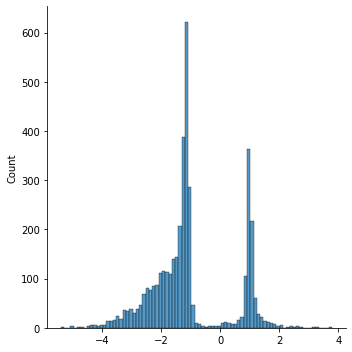

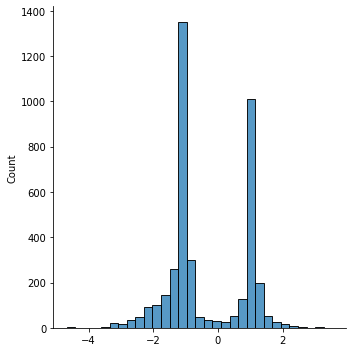

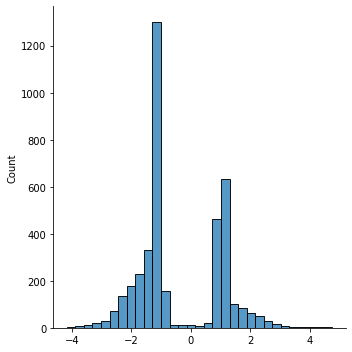

In [15]:
for i in range(3):
  sns.displot(hyperplane[i], kind = 'hist')


**Q7. Model with log loss function**

In [16]:
log_SGD = SGDClassifier(loss='log', penalty='l2',  shuffle=True, alpha=0.0081).fit(X_train, y_train)
y_pred = log_SGD.predict(X_test)
printing_eval_scores (y_test, y_pred, report=True)


accuracy score: 0.674
precision score: 0.682
recall score: 0.674
F1 score: 0.672
              precision    recall  f1-score   support

           0       0.74      0.53      0.62       240
           1       0.58      0.67      0.62       383
           2       0.74      0.77      0.76       379

    accuracy                           0.67      1002
   macro avg       0.69      0.66      0.67      1002
weighted avg       0.68      0.67      0.67      1002



(0.6736526946107785,
 0.6822160620930388,
 0.6736526946107785,
 0.6724978488963647)

**8. Building a linear model to compare the result**

In [17]:
df = pd.DataFrame(zip(id, review, rating, cl_3, cl_4), columns = ['id', 'review', 'rating', '3class', '4class'])
new_df = df[['review', 'rating']].dropna()
new_df = new_df[new_df['rating'] != '']
new_df['rating'] =new_df['rating'].apply(lambda x: float(x))
     
   

In [18]:
new_df['rating'].describe()

count    5006.000000
mean        0.581422
std         0.181725
min         0.000000
25%         0.490000
50%         0.600000
75%         0.700000
max         1.000000
Name: rating, dtype: float64

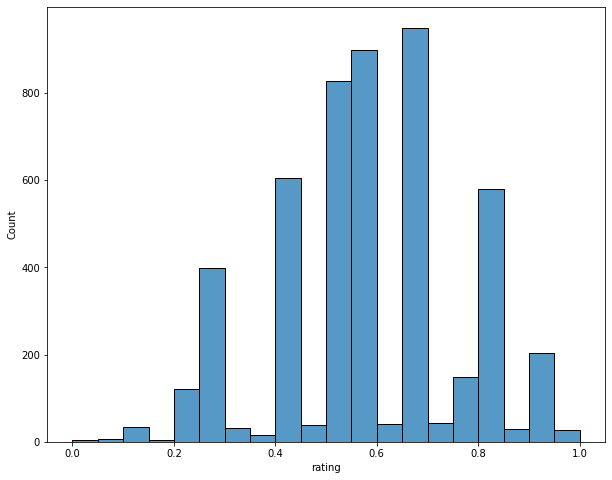

In [19]:
plt.figure(figsize=(10,8))
sns.histplot(data = new_df, x = 'rating', bins = 20)
plt.show()


In [20]:
# Spliting the dataset for training and testing
X_train_, X_test_, y_train_, y_test_ = train_test_split (new_df['review'], new_df['rating'] , train_size = 0.8, random_state = 42, shuffle = True)
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)

Shapes of X_train, y_train:  (4004, 38615) (4004,)
Shapes of X_test, y_test:  (1002, 38615) (1002,)


In [21]:
# Vectorizing the documents
vectorizer = CountVectorizer(binary = True)
X_train_ = vectorizer.fit_transform(X_train_.to_list())
X_test_ = vectorizer.transform(X_test_.to_list())
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)

Shapes of X_train, y_train:  (4004, 38615) (4004,)
Shapes of X_test, y_test:  (1002, 38615) (1002,)


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
reg = LinearRegression().fit(X_train_, y_train_)
y_pred = reg.predict(X_test_)
print('mean squared error: {:.3f}'.format(mean_squared_error(y_test_, y_pred)))
print('r2 score: {:.3f}'.format(r2_score(y_test_, y_pred)))

mean squared error: 0.019
r2 score: 0.430


# Implementing minibatches


In [29]:
from sklearn.linear_model import SGDClassifier
import random
log_SGD_2 = SGDClassifier(loss='log', penalty='l2',  shuffle=True, alpha=0.0081).fit(X_train, y_train)
n_iter = 10
batch_size = 32
for n in range(n_iter):
  n_instances, n_features = X_train.shape
  i=0 
  while i<= round(n_instances/batch_size):
    m = batch_size * i
    n = m + batch_size
    log_SGD_2.partial_fit(X_train[m:n], y_train[m:n], classes=np.unique(y_train))
    i+=1    
  y_pred = svm2.predict(X_test)
  printing_eval_scores(y_test, y_pred, report = True)

accuracy score: 0.663
precision score: 0.670
recall score: 0.663
F1 score: 0.664
              precision    recall  f1-score   support

           0       0.68      0.55      0.61       240
           1       0.58      0.67      0.62       383
           2       0.76      0.73      0.74       379

    accuracy                           0.66      1002
   macro avg       0.67      0.65      0.66      1002
weighted avg       0.67      0.66      0.66      1002

accuracy score: 0.663
precision score: 0.670
recall score: 0.663
F1 score: 0.664
              precision    recall  f1-score   support

           0       0.68      0.55      0.61       240
           1       0.58      0.67      0.62       383
           2       0.76      0.73      0.74       379

    accuracy                           0.66      1002
   macro avg       0.67      0.65      0.66      1002
weighted avg       0.67      0.66      0.66      1002

accuracy score: 0.663
precision score: 0.670
recall score: 0.663
F1 score: 0

In [27]:
y_pred = svm2.predict(X_test)
printing_eval_scores(y_test, y_pred, report = True)

accuracy score: 0.663
precision score: 0.670
recall score: 0.663
F1 score: 0.664
              precision    recall  f1-score   support

           0       0.68      0.55      0.61       240
           1       0.58      0.67      0.62       383
           2       0.76      0.73      0.74       379

    accuracy                           0.66      1002
   macro avg       0.67      0.65      0.66      1002
weighted avg       0.67      0.66      0.66      1002



(0.6626746506986028,
 0.6702598166934688,
 0.6626746506986028,
 0.6635213089807721)